# **Trying to use TROCR to recognize text in images**

In [1]:
# set the wandb loggin on our kaggle notebook
!pip install --upgrade wandb --quiet
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb") 

wandb.login(key=wandb_api)
wandb_name = wandb.util.generate_id()
wandb.init(project="ocr", name=wandb_name)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: elskow. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230706_082213-0zvml26r
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sdi30iur
wandb: ⭐️ View project at https://wandb.ai/elskow/ocr
wandb: 🚀 View run at https://wandb.ai/elskow/ocr/runs/0zvml26r


## .env

> setup the path of the data

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.202
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa

In [3]:
import psutil

# Get the system memory size (in bytes)
ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / 1e9:.2f} GB")

Total RAM: 16.78 GB


In [4]:
!nvidia-smi

Thu Jul  6 08:22:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [5]:
def reduce_memory_usage():
    import gc
    import torch
    
    gc.collect()
    torch.cuda.empty_cache()

    import psutil
    import os

    process = psutil.Process(os.getpid())
    print(f'Used Memory: {process.memory_info().rss / 1024 ** 2:.2f} MB')

reduce_memory_usage()

Used Memory: 518.87 MB


In [6]:
import os

In [7]:
# check are the data exist or not, if not change the path
try:
    csv_train = "/kaggle/input/unprocessedcsvsatriadata/DataTrainwithoutcleaninglabel.csv"
    csv_test = "/kaggle/input/preprocessedsatdat/DataTest.csv"

    assert os.path.exists(csv_train)
    assert os.path.exists(csv_test)

except:
    csv_train = "out/DataTrain.csv"
    csv_test = "out/DataTest.csv"

    assert os.path.exists(csv_train)
    assert os.path.exists(csv_test)

In [8]:
try:
    folder_of_train = '/kaggle/input/opening-data/preprocessed_train_data'
    folder_of_test = '/kaggle/input/preprocessedsatdat/preprocessed_test_data'

    assert os.path.exists(folder_of_train)
    assert os.path.exists(folder_of_test)

except:
    folder_of_train = 'preprocessed_train_data'
    folder_of_test = 'preprocessed_test_data'

    assert os.path.exists(folder_of_train)
    assert os.path.exists(folder_of_test)

In [9]:
output_dir = 'out'
os.makedirs(output_dir, exist_ok=True)

## code

In [10]:
# !pip install --upgrade pip --quiet # for tpu kaggle
!pip install -q datasets jiwer --quiet
!pip install --upgrade accelerate --quiet
# !pip install transformers --quiet # for tpu kaggle
# !pip install torch --quiet # for tpu kaggle
# !pip install scikit-learn # for tpu kaggle

In [11]:
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd

import cv2
import json
from PIL import Image

from transformers import TrOCRProcessor, VisionEncoderDecoderModel

import torch
from torch.utils.data import Dataset

from datasets import load_metric

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

# Import and add img path

In [12]:
training_data = pd.read_csv(csv_train)
testing_data = pd.read_csv(csv_test)

In [13]:
training_data

,img,label
0,DataTrain1.png,A7814
1,DataTrain2.png,B1074QO
2,DataTrain3.png,B1031QO
3,DataTrain4.png,B187EDA
4,DataTrain5.png,B1089VD
...,...,...
608,DataTrain795.png,B1269MA
609,DataTrain796.png,B1677EJC
610,DataTrain797.png,B1743VO
611,DataTrain798.png,AD1416YD


In [14]:
# add image path
# for example : 
# on img column, we have 'DataTrain2.png'.
# so, we add 'preprocessed_train_data/DataTrain2.png' to img_path column

# first of all, check are the image exist or not
def img_path(img_name, folder):
    path = os.path.join(folder, img_name)
    if os.path.exists(path):
        return path
    else:
        return np.nan

training_data['img_path'] = training_data['img'].apply(lambda x: img_path(x, folder_of_train))
testing_data['img_path'] = testing_data['img'].apply(lambda x: img_path(x, folder_of_test))

# print none image path
print('none image path on training data : ', training_data['img_path'].isna().sum())
print('none image path on testing data : ', testing_data['img_path'].isna().sum())

training_data.drop('img', axis=1, inplace=True)

training_data

none image path on training data :  0
none image path on testing data :  0


,label,img_path
0,A7814,/kaggle/input/opening-data/preprocessed_train_...
1,B1074QO,/kaggle/input/opening-data/preprocessed_train_...
2,B1031QO,/kaggle/input/opening-data/preprocessed_train_...
3,B187EDA,/kaggle/input/opening-data/preprocessed_train_...
4,B1089VD,/kaggle/input/opening-data/preprocessed_train_...
...,...,...
608,B1269MA,/kaggle/input/opening-data/preprocessed_train_...
609,B1677EJC,/kaggle/input/opening-data/preprocessed_train_...
610,B1743VO,/kaggle/input/opening-data/preprocessed_train_...
611,AD1416YD,/kaggle/input/opening-data/preprocessed_train_...


In [15]:
# add training data with image invertation
def img_inv(img):
    return cv2.bitwise_not(img)

def create_new_img(img_path, invert):
    img = cv2.imread(img_path)
    if invert:
        img = img_inv(img)
    return img

os.mkdir('/kaggle/working/augmented_data')

def data_augmentation(df):
    new_df = pd.DataFrame(columns=df.columns)
    for i in range(len(df)):
        img_path = df.iloc[i]['img_path']
        label = df.iloc[i]['label']
        for invert in [True, False]:
            new_img = create_new_img(img_path, invert)
            new_image_name = df.iloc[i]['img_path'].split('/')[-1].split('.')[0] + '_' + str(invert) + '.png'
            new_img_path = os.path.join('/kaggle/working/augmented_data', new_image_name)
            cv2.imwrite(new_img_path, new_img)
            new_df = new_df.append({'img_path': new_img_path, 'label': label}, ignore_index=True)
    return new_df

training_data = data_augmentation(training_data)

training_data

,label,img_path
0,A7814,/kaggle/working/augmented_data/DataTrain1_True...
1,A7814,/kaggle/working/augmented_data/DataTrain1_Fals...
2,B1074QO,/kaggle/working/augmented_data/DataTrain2_True...
3,B1074QO,/kaggle/working/augmented_data/DataTrain2_Fals...
4,B1031QO,/kaggle/working/augmented_data/DataTrain3_True...
...,...,...
1221,B1743VO,/kaggle/working/augmented_data/DataTrain797_Fa...
1222,AD1416YD,/kaggle/working/augmented_data/DataTrain798_Tr...
1223,AD1416YD,/kaggle/working/augmented_data/DataTrain798_Fa...
1224,AB5419TN,/kaggle/working/augmented_data/DataTrain799_Tr...


In [16]:
from sklearn.model_selection import train_test_split

# # create test data from training data, take 25 rows and remove it from training data ( For testing the accuracy )
# test_df = training_data.sample(20, random_state=42)
# training_data = training_data.drop(test_df.index)

train_df, valid_df = train_test_split(training_data, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)

print('train_df shape : ', train_df.shape)
print('valid_df shape : ', valid_df.shape)

train_df

train_df shape :  (980, 2)
valid_df shape :  (246, 2)


,label,img_path
0,B1241PQO,/kaggle/working/augmented_data/DataTrain165_Tr...
1,B1532NKY,/kaggle/working/augmented_data/DataTrain700_Fa...
2,B1972RBP,/kaggle/working/augmented_data/DataTrain6_True...
3,B1820UL,/kaggle/working/augmented_data/DataTrain309_Fa...
4,B1486TJJ,/kaggle/working/augmented_data/DataTrain238_Tr...
...,...,...
975,B1925SYG,/kaggle/working/augmented_data/DataTrain665_Tr...
976,B1658YU,/kaggle/working/augmented_data/DataTrain699_Fa...
977,B017QO,/kaggle/working/augmented_data/DataTrain725_Tr...
978,B1830DFD,/kaggle/working/augmented_data/DataTrain531_Tr...


In [17]:
reduce_memory_usage()

Used Memory: 1117.58 MB


# Modelling the TROCR

In [18]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# If you want to start from the pretrained model, load the checkpoint with `VisionEncoderDecoderModel`
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')

# TrOCR is a decoder model and should be used within a VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import torch
from torch.utils.data import Dataset

class LPDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['img_path'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

    def __iter__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

In [20]:
root_dir = ''

train_dataset = LPDataset(root_dir, train_df, processor)
eval_dataset = LPDataset(root_dir, valid_df, processor)

In [21]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 9
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 2

In [22]:
print(model.config.decoder.decoder_start_token_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

2


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [23]:
from datasets import load_metric

cer_metric = load_metric("cer")

In [24]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [25]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    fp16=True,
    overwrite_output_dir=True,
    output_dir=output_dir,
    logging_steps=7,
    save_steps=1000,
    eval_steps=50,
    report_to='wandb',
    run_name='trocr-base-printed',
    metric_for_best_model="cer",
    seed=42,
    num_train_epochs=10,
    dataloader_num_workers=4,
    greater_is_better=False,
)


# initiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [26]:
reduce_memory_usage()

Used Memory: 3725.84 MB


In [27]:
trainer.train()

Step,Training Loss,Validation Loss,Cer
50,0.496400,0.443215,0.103153
100,0.259000,0.329574,0.087119
150,0.233200,0.328986,0.080171
200,0.113300,0.298631,0.067344
250,0.055600,0.257262,0.057189
300,0.022200,0.228945,0.049172
350,0.010300,0.185680,0.041154
400,0.014400,0.179770,0.035275
450,0.002500,0.176132,0.037413


TrainOutput(global_step=490, training_loss=0.17179250214320171, metrics={'train_runtime': 1548.2852, 'train_samples_per_second': 6.33, 'train_steps_per_second': 0.316, 'total_flos': 7.333194871760486e+18, 'train_loss': 0.17179250214320171, 'epoch': 10.0})

In [28]:
save_time = time.time()
model.save_pretrained("/kaggle/working/ocr")
save_time = time.time() - save_time
print('save_time time (sec)', save_time)

save_time time (sec) 2.193397045135498


In [29]:
score_model = VisionEncoderDecoderModel.from_pretrained('/kaggle/working/ocr')

In [30]:
reduce_memory_usage()

Used Memory: 9255.19 MB


In [31]:
evaluation = trainer.evaluate()

print(evaluation)

{'eval_loss': 0.1726042628288269, 'eval_cer': 0.03527525387493319, 'eval_runtime': 50.6988, 'eval_samples_per_second': 4.852, 'eval_steps_per_second': 0.256, 'epoch': 10.0}


In [32]:
reduce_memory_usage()

Used Memory: 9216.95 MB


# Testing Model

AB3787KE
score_time (sec) 0.22794437408447266


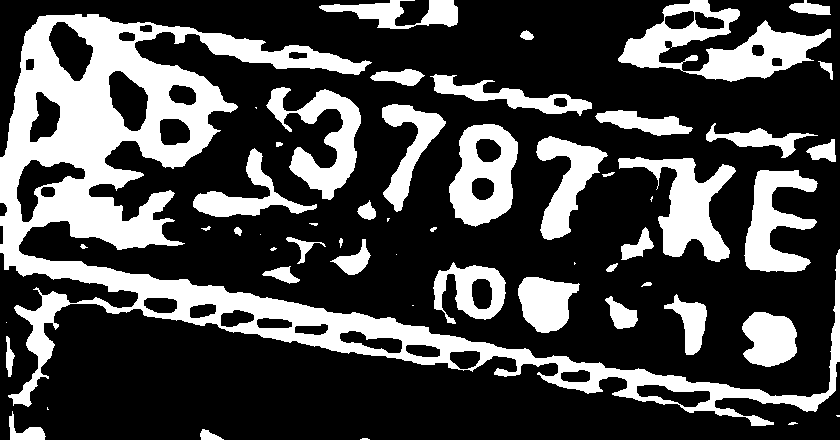

In [33]:
file_image = '/kaggle/input/preprocessedsatdat/preprocessed_test_data/DataTest85.png'
# image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image = Image.open(file_image).convert("RGB")
score_time = time.time()

pixel_values = processor(image, return_tensors="pt").pixel_values
# text = "industry, ' Mr. Brown commented icily. ' Let us have a"
# if torch.cuda.is_available():
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pixel_values = pixel_values.to(device)
# # inference
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

score_time = time.time() - score_time
print('score_time (sec)', score_time)

image

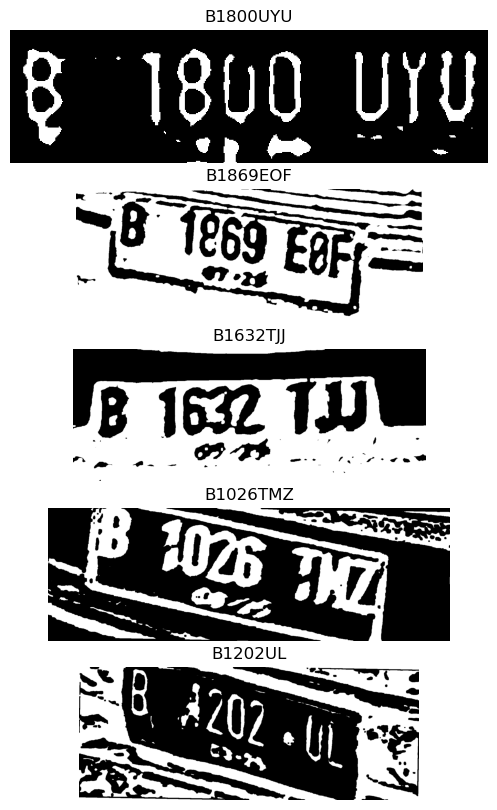

In [34]:
random_pics = " ".join([f"DataTest{i}.png" for i in np.random.choice(100, 5, replace=False)])

fig, ax = plt.subplots(5, 1, figsize=(20, 10))

for i, pic in enumerate(random_pics.split()):
    image = Image.open(os.path.join(folder_of_test, pic)).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    ax[i].imshow(image)
    ax[i].set_title(generated_text)
    ax[i].axis("off")

plt.show()

# Test the accuracy of the model using random on test_set

In [35]:
# correct_char = 0
# total_char = 0
# correct = 0

# # test the model accuracy on test set
# for imges_path in test_df['img_path']:
#     image = Image.open(imges_path).convert("RGB")
#     pixel_values = processor(image, return_tensors="pt").pixel_values
#     pixel_values = pixel_values.to(device)
#     generated_ids = model.generate(pixel_values)
#     generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
#     true_text = test_df[test_df['img_path'] == imges_path]['label'].values[0]
#     correct_char += cer_metric.compute(predictions=[generated_text], references=[true_text])
#     total_char += len(true_text)
#     if generated_text == true_text:
#         correct += 1

# print('Accuracy on test set', correct / len(test_df))
# print('CER on test set', correct_char / total_char)

# Making Pred on Testset

In [36]:
# making pred on testing dataframe
pred = []

for imges_path in testing_data['img_path']:
    image = Image.open(imges_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    pred.append(generated_text)

testing_data['Vehicleregistrationplatebymodel'] = pred

# change the 'img' column to 'Name of File'
testing_data.rename(columns={'img': 'Name of File'}, inplace=True)

testing_data.drop('img_path', axis=1, inplace=True)

testing_data.head()

,Name of File,Vehicleregistrationplatebymodel
0,DataTest1.png,AD7034OE
1,DataTest2.png,A9388EX
2,DataTest3.png,B16TB
3,DataTest4.png,B1661TKZ
4,DataTest5.png,AD3772ABE


In [37]:
testing_data.to_csv('/kaggle/working/submission.csv')
wandb.save('/kaggle/working/submission.csv')

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/kaggle/working/wandb/run-20230706_082213-0zvml26r/files/submission.csv']

# Wandb logger

In [40]:
wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:                       accuracy ▁
wandb:                       eval/cer █▆▆▄▃▂▂▁▁▁
wandb:                      eval/loss █▅▅▄▃▂▁▁▁▁
wandb:                   eval/runtime █▃▄▆▂▄▁▁▁▆
wandb:        eval/samples_per_second ▁▆▅▂▇▅███▃
wandb:          eval/steps_per_second ▁▆▅▂▇▅███▃
wandb:                    train/epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:              train/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
wandb:            train/learning_rate ███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                     train/loss █▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:               train/total_flos ▁
wandb:               train/train_loss ▁
wandb:            train/train_runtime ▁
wandb: train/train_samples_per_second ▁
wandb:   train/train_steps_per_second ▁
wandb: 
wandb: Run summary:
wandb:                       accuracy 0.9645
wandb:                       eval/cer 0.035